# Using Keras with TensorFlow eager mode, on the 'Fashion MNIST' dataset

In this notebook, we'll use [TensorFlow's new eager execution mode](https://www.tensorflow.org/programmers_guide/eager).

In [1]:
import tensorflow as tf
# The TF version should be >= 1.7
print(tf.__version__)

1.7.0


In [2]:
from tensorflow import keras

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D

Enable eager execution for this program. Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a [computational graph](https://www.tensorflow.org/programmers_guide/graphs) that is executed later. If you are used to a REPL or the `python` interactive console, you'll feel at home.

Once eager execution is enabled, it *cannot* be disabled within the same program. See the [eager execution guide](https://www.tensorflow.org/programmers_guide/eager) for more details.

In [ ]:
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

Import the 'Fashion MNIST' dataset, this time via the Keras `datasets` module.

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Define a CNN model using Keras.

In [5]:
num_classes = 10

model = tf.keras.Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              ?                         401920    
_________________________________________________________________
dropout_1 (Dropout)          ?                         0         
_________________________________________________________________
dense_2 (Dense)              ?                         262656    
_________________________________________________________________
dropout_2 (Dropout)          ?                         0         
_________________________________________________________________
dense_3 (Dense)              ?                         5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


TensorFlow's [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) handles many common cases for feeding data into a model. This is a high-level API for reading data and transforming it into a form used for training. See the [Datasets Quick Start guide](https://www.tensorflow.org/get_started/datasets_quickstart) for more information.
Datasets work with TensorFlow Eager mode.

In [6]:
BATCH_SIZE = 128
SHUFFLE_SIZE = 1000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
          .shuffle(SHUFFLE_SIZE) \
          .batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
          .batch(BATCH_SIZE)

# View a single example entry from a batch
#features, labels = tfe.Iterator(test_dataset).next()
#print("example feature:", features[0])
#print("example label:", labels[0])


### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [tf.losses.sparse_softmax_cross_entropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy) function which takes the model's prediction and the desired label. The returned loss value is progressively larger as the prediction gets worse.

In [7]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tfe.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)


### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="http://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorthims visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorthims visualized over time in 3D space. (Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License)<br/>&nbsp;
  </td></tr>
</table>

TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

In [8]:
optimizer = tf.train.AdamOptimizer()

Now we'll run a training loop, applying the gradients tape as defined above.

In [ ]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of BATCH_SIZE
  for images, labels in tfe.Iterator(train_dataset):
    # Optimize the model
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, images, labels))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(images), axis=1, output_type=tf.int32), labels)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
#  if epoch % 50 == 0:
  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
    

We can plot the training loss and accuracy.

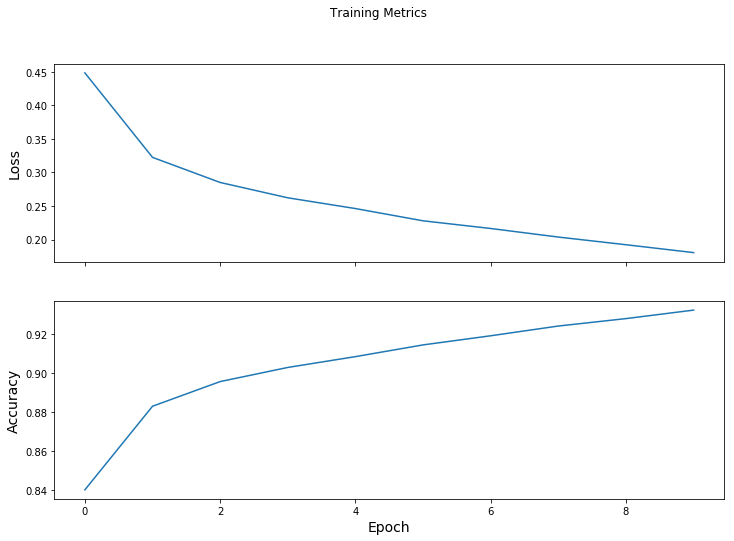

In [10]:
# Skip this cell if you don't have matplotlib installed
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

Now let's look at how our model does with the test set:

In [ ]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

<hr>
Copyright 2018 Google Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

 http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.